## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [50]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [51]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [52]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [53]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [54]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBBSSB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
499
+-------------------+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
|            coeff_1|           coeff_2|           coeff_3|           coeff_4|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|             res_3|              res_4|          res_mean|    station|   total_var|undefs|              vector|  year|
+-------------------+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
|-3975.9681279375172|2226.5193552251358|324.35763807368517|-294.4

In [66]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|USC00420086| 37.4403|-112.4819|   2145.8|-3975.9681279375172|
|USC00420900| 37.6933|-112.8469|   2977.9|-12587.643158893527|
|USC00420900| 37.6933|-112.8469|   2977.9|-12956.464704805787|
|USC00420900| 37.6933|-112.8469|   2977.9|-13492.556735554957|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [67]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(50)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
2,USC00260099,37.3667,-115.1667,-999.9,1,358.254596
37,USC00261358,37.6128,-114.5264,1334.7,4,219.785875
34,USC00266252,37.9344,-114.4500,1825.8,13,-248.829036
11,USC00420086,37.4403,-112.4819,2145.8,47,-1419.747921
17,USC00420738,37.6131,-109.4847,1838.6,27,-171.127608
6,USC00420757,37.5928,-112.8639,3259.5,18,-9922.476262
26,USC00420788,37.2825,-109.5575,1316.4,3,277.948309
27,USC00420849,37.9050,-111.4200,2036.1,21,-55.037928
29,USC00420900,37.6933,-112.8469,2977.9,7,-12505.639150
36,USC00421006,37.6333,-112.1833,2425.0,7,-2846.384195


In [86]:
df10 = df1.groupby(['elevation']).agg({"station": "count", feature: "mean"})
pdf10=df10.toPandas()
pdf10.sort_values(by=['elevation'],inplace=True)
pdf10.head(39)

,elevation,count(station),avg(coeff_1)
19,-999.9,1,358.254596
8,1252.7,2,419.006301
4,1316.4,3,277.948309
11,1334.7,4,219.785875
23,1402.1,2,488.384271
34,1552.0,1,-3.305270
31,1569.7,5,194.600868
24,1574.9,6,328.494971
9,1621.5,12,275.054177
37,1664.2,26,159.984829


In [68]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [69]:
# find the minimum and maximum latitude and longitude.
min_lat = sqlContext.sql("SELECT MIN(latitude) as min_lat FROM weather").collect()[0].min_lat
max_lat = sqlContext.sql("SELECT MAX(latitude) as max_lat FROM weather").collect()[0].max_lat
min_long = sqlContext.sql("SELECT MIN(longitude) as min_long FROM weather").collect()[0].min_long
max_long = sqlContext.sql("SELECT MAX(longitude) as max_long FROM weather").collect()[0].max_long
#min_coef1 = sqlContext.sql("SELECT MIN(avg(coeff1)) as min_coef1 as min_long FROM weather").collect()[0].min_coef1
#max_coef1 = sqlContext.sql("SELECT MAX(avg(coeff1)) as max_coef1 as min_long FROM weather").collect()[0].min_coef1
print min_lat,max_lat,min_long,max_long 
#min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)

37.2722 38.0 -115.1667 -109.0828


In [70]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    #c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
    #        color='#F00', opacity=0.8, fill_opacity=0.4,
    #        fill_color=get_color(_coef))
    c = Circle(location=(_lat,_long), radius=int(2000*(_coef/1000+1)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4)
    circles.append(c)
    m.add_layer(c)
m    

In [60]:
loc_avg_coef1_df = sqlContext.sql("SELECT latitude, longitude, AVG(coeff_1) FROM weather GROUP BY latitude, longitude")
loc_avg_coef1_df.show(5)



+--------+---------+------------------+
|latitude|longitude|      avg(coeff_1)|
+--------+---------+------------------+
| 37.5142|-111.9883|42.470957313437815|
| 37.7086|-113.0944|127.21392310660781|
| 37.2806|-113.7283| 419.0063007147681|
| 37.5928|-112.8639| -9922.47626230756|
| 37.6478|-112.4331|-541.1741852071417|
+--------+---------+------------------+
only showing top 5 rows



### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

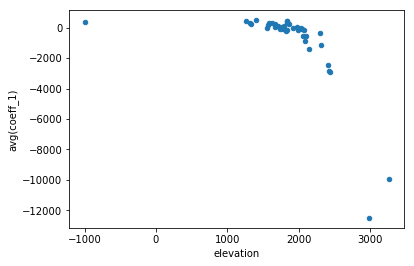

In [11]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [12]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']

In [41]:
sc.stop()